# NIRCAM - Finding and validating the location of object specta for the WFSS mode
There are no NIRCAM grism simulations available here: http://archive.stsci.edu/jwst/simulations/nircam.html
so the following example uses images supplied by the team. Contact Bryan Hilbert.


## Make sure that you have set the JWST_NOTEBOOK_DATA environment variable in the terminal from which you started Jupyter Notebook.

The data will be read from that directory, and the pipeline should write to the current working directory, avoiding clobbers.
If you would like to use your own data just substitute the locations below.

In [1]:
# plotting, the inline must come before the matplotlib import
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patches

params = {'legend.fontsize': 6,
          'figure.figsize': (8, 8),
          'figure.dpi': 150,
         'axes.labelsize': 6,
         'axes.titlesize': 6,
         'xtick.labelsize':6,
         'ytick.labelsize':6}
plt.rcParams.update(params)


# python general
import os
import numpy as np

# astropy modules
import astropy
from astropy.io import fits
from astropy.table import QTable
from astropy.wcs.utils import skycoord_to_pixel
import photutils

# jwst 
import jwst
from jwst.source_catalog import source_catalog_step
from jwst.datamodels import image, DrizProductModel, WavelengthrangeModel
from jwst import assign_wcs
from jwst.assign_wcs import assign_wcs_step

In [2]:
print("Using jwst pipeline version: {}\nastropy version: {}\n photutils version: {}".format(jwst.__version__, astropy.__version__, photutils.__version__ ))

Using jwst pipeline version: 0.13.0b.dev174
astropy version: 3.2.dev23553
 photutils version: 0.7.dev3303


## Example model data from the science team

    NIRCam WFSS datasets for pipeline testing:

    12 pointings (3 dither positions, with 4 subpixel dithers),
    for each of row and column dispersed spectra. Associated direct
    images and out-of-field observations, along with
    all of the associated shortwave channel data, which is
    all imaging mode.


    Filenames are (e.g.) V54321001002P0000000001101_A1_F150W_uncal.fits
    for imaging files, and
    V54321001003P0000000001116_A5_F444W_FinalDispersedRamp_XXX_uncal.fits
    for dispersed files, where XXX can be 'row' or 'column'.



    Cheat sheet:
    File numbers below are the 4 digits immediately before the first
    underscore in the filename.


    File number       Description


    **************************************
    ********Observation 2*****************

    1101 - 1109       LW:12 dithered grism observations, row dispersed, and
    110a - 110c       complimentary SW imaging data

    110d              LW: Direct image, SW: complimentary imaging data

    110e and 110f     out-of-field observations

    110g to 110r      LW:12 dithered grism observations, column dispersed,
                      and SW: complimentary imaging data

    110s              LW: Direct image, SW: complimentary imaging data

    110t and 110u     out-of-field observations
    
    **************************************
    *********Observation 3****************
    110v - 110z       LW:12 dithered grism observations, row dispersed, and
    1110 - 1116       SW:complimentary imaging data

    1117              LW: Direct image, SW: complimentary imaging data

    1118 - 1119       out-of-field observations

    111a - 111l       LW:12 dithered grism observations, column dispersed,
                      and SW: complimentary imaging data

    111m              LW: Direct image, SW: complimentary imaging data

    111n - 111o       out-of-field observations




### I've selected the following datasets to use as examples in this notebook. The other datasets can also be validated in the same manner.

#### Row dispersed data
    V54321001002P000000000110d_A5_F444W_rate.fits
    V54321001002P0000000001101_A5_F444W_FinalDispersedRamp_row_rate.fits

#### Column dispersed data
    V54321001002P000000000110g_A5_F444W_FinalDispersedRamp_column_rate.fits
    V54321001002P000000000110s_A5_F444W_rate.fits


In [3]:
notebook_dir = os.environ['JWST_NOTEBOOK_DATA']
nircam_data = notebook_dir + 'nircam/'

grismr_file = nircam_data + 'V54321001002P0000000001101_A5_F444W_FinalDispersedRamp_row_rate.fits'  # this is a row dispersed grism image
directr_file = nircam_data + 'V54321001002P000000000110d_A5_F444W_rate.fits'  # this is a filtered image
grismc_file = nircam_data + 'V54321001002P000000000110g_A5_F444W_FinalDispersedRamp_column_rate'  # this is a column dispersed grism image
directc_file = nircam_data + 'V54321001002P000000000110s_A5_F444W_rate.fits'  # this is a filtered image

#### let's look at what the row dispersed images contain

You should already be able to tell the grism image was taken at a different pointing that the direct image

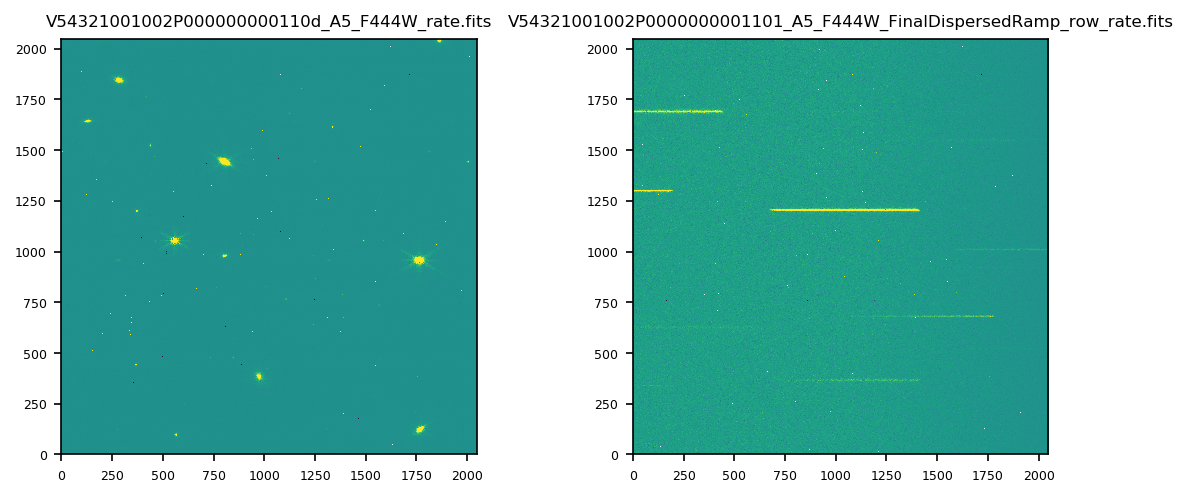

In [4]:
dispim=fits.open(grismr_file)
dirim=fits.open(directr_file)
ys,xs=dirim[1].data.shape
fig = plt.figure(figsize=(8,8), dpi=150)
ax = fig.add_subplot(1, 2, 1)
ax.set_title(directr_file.split("/")[-1], fontsize=8)
ax.imshow(dirim[1].data, origin='lower', extent=[0,xs,0,ys], vmin=-3, vmax=3)
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title(grismr_file.split("/")[-1], fontsize=8)
ax2.imshow(dispim[1].data, origin='lower', extent=[0,xs,0,ys], vmin=-3, vmax=3)
fig.tight_layout()
fig.savefig('nircam_image_comparison.jpg')
dispim.close()
dirim.close()

#### You should be able to tell from the above images that the grism image has been taken at a different pointing from the direct image

## We are going to create a source catalog for our direct image
If you've already worked through the notebook in general/Create-Source-Catalog notebook the following cells will look familiar

#### Create the source catalog step object

In [5]:
sc=source_catalog_step.SourceCatalogStep(save_results=True)

2019-01-11 14:54:37,258 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.


In [6]:
print(sc.spec)  # display the defaults


        kernel_fwhm = float(default=2.0)      # Gaussian kernel FWHM in pixels
        kernel_xsize = float(default=5)       # Kernel x size in pixels
        kernel_ysize = float(default=5)       # Kernel y size in pixels
        snr_threshold = float(default=3.0)    # SNR threshold above the bkg
        npixels = float(default=5.0)          # min number of pixels in source
        deblend = boolean(default=False)      # deblend sources?
        output_ext = string(default='.ecsv')  # Default type of output
        suffix = string(default='cat')        # Default suffix for output files
    


### Open our image as a datamodel and find the sources

In [7]:
dpm=DrizProductModel(directr_file)

#### check out some quick information about the image we are using

In [8]:
dpm.meta.subarray.name, dpm.meta.instrument.name, dpm.meta.instrument.detector, dpm.meta.instrument.channel, dpm.meta.instrument.filter, dpm.meta.instrument.pupil, dpm.meta.instrument.module, dpm.meta.exposure.type

('FULL', 'NIRCAM', 'NRCALONG', 'LONG', 'F444W', 'CLEAR', 'A', 'NRC_IMAGE')

In [9]:
# Add this if your direct image hasn't been through resample
dpm.meta.resample.product_exposure_time = dpm.meta.exposure.exposure_time

In [10]:
# source catalog is using get_fits_wcs() and that barfs on the DrizProdModel if validation fails on VAR_POISSON and VAR_RNOISE
# those don't exist are set to unloaded arrays in the model, so here  we'll set them.

dpm.var_poisson = 0
dpm.var_rnoise = 0

In [11]:
fits.info(directr_file)

Filename: /Users/sosey/ssb/jwst-pipeline/jwst-pipeline-notebooks/data/nircam/V54321001002P000000000110d_A5_F444W_rate.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     139   ()      
  1  SCI           1 ImageHDU        45   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  6  ASDF          1 ImageHDU         7   (4171,)   uint8   
  7  WHT           1 ImageHDU         8   (2048, 2048)   float32   


In [12]:
sc.process(dpm)

2019-01-11 14:54:50,152 - stpipe - WARNING - /Users/sosey/miniconda3/envs/jwstdev/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:286: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  AstropyUserWarning)

2019-01-11 14:54:51,950 - stpipe - WARNING - /Users/sosey/miniconda3/envs/jwstdev/lib/python3.6/site-packages/photutils/segmentation/detect.py:128: RuntimeWarning: invalid value encountered in greater
  check_normalization=True) > threshold)

2019-01-11 14:54:52,154 - stpipe - WARNING - /Users/sosey/miniconda3/envs/jwstdev/lib/python3.6/site-packages/jwst-0.13.0b0.dev174-py3.6-macosx-10.7-x86_64.egg/jwst/source_catalog/source_catalog.py:126: RuntimeWarning: invalid value encountered in maximum
  total_error = np.sqrt(data_std**2 + np.maximum(model.data / exptime, 0))

2019-01-11 14:54:52,270 - stpipe - WARNING - /Users/sosey/miniconda3/envs/jwstdev/lib/python3.6/site-packages/astropy/io/fits/card.py:979: VerifyWarni

#### The above results should print out the name of the catalog that was created, my first run showed 2718 with the default parameters, we'll change that to get better detections below

#### If you see a TypeError, it's most likely because your image hasn't been sent through resample so it's missing a WHT extension and some meta information. We can add one ourselves and continue. If not, you can skip the following cells.

In [13]:
# execute to add WHT extension to dataset
dirim = fits.open(directr_file, mode='update')

WHT = False
for extname in dirim:
    if 'WHT' in extname.name:
        WHT = True
if not WHT:
    wht_hdu = fits.ImageHDU()
    wht_hdu.data = np.ones((2048, 2048), dtype=np.float32)
    wht_hdu.data
    wht_hdu.header['EXTNAME'] = 'WHT'
    dirim.append(wht_hdu)
else:
    print("WHT extension already exists, no update")
    
dirim.close()

WHT extension already exists, no update


In [14]:
fits.info(directr_file)

Filename: /Users/sosey/ssb/jwst-pipeline/jwst-pipeline-notebooks/data/nircam/V54321001002P000000000110d_A5_F444W_rate.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     139   ()      
  1  SCI           1 ImageHDU        45   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  6  ASDF          1 ImageHDU         7   (4171,)   uint8   
  7  WHT           1 ImageHDU         8   (2048, 2048)   float32   


#### Edit the defaults for source finding and run again to get a better detection sample


In [15]:
sc.npixels=50
sc.snr_threshold=30
sc.process(dpm)

2019-01-11 14:55:01,141 - stpipe - WARNING - /Users/sosey/miniconda3/envs/jwstdev/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:286: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  AstropyUserWarning)

2019-01-11 14:55:02,725 - stpipe - WARNING - /Users/sosey/miniconda3/envs/jwstdev/lib/python3.6/site-packages/photutils/segmentation/detect.py:128: RuntimeWarning: invalid value encountered in greater
  check_normalization=True) > threshold)

2019-01-11 14:55:02,837 - stpipe - WARNING - /Users/sosey/miniconda3/envs/jwstdev/lib/python3.6/site-packages/jwst-0.13.0b0.dev174-py3.6-macosx-10.7-x86_64.egg/jwst/source_catalog/source_catalog.py:126: RuntimeWarning: invalid value encountered in maximum
  total_error = np.sqrt(data_std**2 + np.maximum(model.data / exptime, 0))

2019-01-11 14:55:02,880 - stpipe - WARNING - /Users/sosey/miniconda3/envs/jwstdev/lib/python3.6/site-packages/astropy/io/fits/card.py:979: VerifyWarni

In [16]:
skycoord_cat='step_SourceCatalogStep_cat.ecsv'  # this should be the name in the output listing above
#skycoord_cat='V54321001002P000000000110d_A5_F444W_rate_cat.ecsv'
catalog=QTable.read(skycoord_cat,  format='ascii.ecsv')
catalog

<QTable length=26>
  id      xcentroid          ycentroid      ...  abmag  abmag_error
             pix                pix         ...                    
int64      float64            float64       ... float64   float32  
----- ------------------ ------------------ ... ------- -----------
    1  566.5884580067268  95.01738214939468 ...     nan         nan
    2  1768.356510600382 120.89696843514946 ...     nan         nan
    3   974.981903579752 380.88236906246266 ...     nan         nan
    4 369.92507863061206  440.0472069383215 ...     nan         nan
    5  848.5632069398413  472.7131103403137 ...     nan         nan
    6 1563.8032761238346  733.2698111309755 ...     nan         nan
    7  815.8331350886955  758.3001435721127 ...     nan         nan
    8 1106.7585647961853  762.6868094643409 ...     nan         nan
    9 1762.8446187443838   953.654293812466 ...     nan         nan
  ...                ...                ... ...     ...         ...
   17  372.7343851300843 1196.3601779774813 ...     nan         nan
   18  578.9047581360659   1203.76188337848 ...     nan         nan
   19  805.2922935370586  1438.978856541085 ...     nan         nan
   20  2005.397574127638  1437.827820824233 ...     nan         nan
   21 1811.6351045588221 1489.6236796206585 ...     nan         nan
   22  439.3534687856962 1518.1198870893284 ...     nan         nan
   23  1336.316431146143 1611.1469547193703 ...     nan         nan
   24 131.15685574652738 1638.1239744841605 ...     nan         nan
   25  286.2709905740931 1840.4092996608497 ...     nan         nan
   26 1861.9024039098492 2035.4605774853148 ...     nan         nan

#### the `source_catalog` step returns the xcentroid and ycentroid in pixel values, let's plot those over our image to see how the detections look

Saved image to nircam_wfss_catalog_centers.jpg


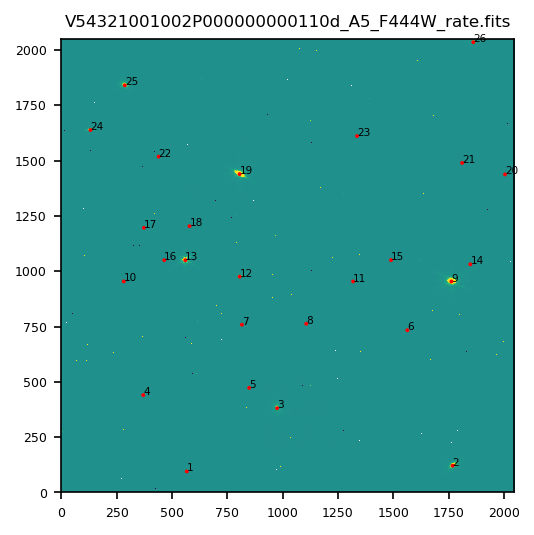

In [17]:
dirim = fits.getdata(directr_file, ext=1)
xs,ys=dirim.shape
fig = plt.figure(figsize=(4,4), dpi=150)
ax = fig.add_subplot(1, 1, 1)
ax.ticklabel_format(useOffset=False)
ax.ticklabel_format(useOffset=False)
ax.set_title(directr_file.split("/")[-1], fontsize=8)
ax.imshow(dirim, origin='lower', extent=[0,xs,0,ys], vmin=-10, vmax=10)

# rectangle patches are xmin, ymin, width, height
plist1=[]
for obj in catalog:
    plist1.append(patches.Circle((obj['xcentroid'].value, obj['ycentroid'].value),4, color='red'))
    ax.text(obj['xcentroid'].value, obj['ycentroid'].value, obj['id'], size=5)

for p in plist1:
    ax.add_patch(p)
    
ax.imshow(dirim, origin='lower', extent=[0,xs,0,ys], vmin=-10, vmax=10)
print("Saved image to nircam_wfss_catalog_centers.jpg")
fig.savefig('nircam_wfss_catalog_centers.jpg')

### source_catalog returns the minimal bounding boxes around each object in units of degrees:
* sky_bbox_ll
* sky_bbox_ul
* sky_bbox_lr
* sky_bbox_ur

#### Let's translate those corners so that we can overplot our bounding boxes for each object
**Caveat, as of the writing of this notebook, source_catalog hasn't been fully updated to use GWCS objects, so we are going to do the radec --> pixel translation using the fits wcs in the model 

In [18]:
wcs = dpm.get_fits_wcs(hdu_name='SCI')

In [19]:
wcs.celestial

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.1490299775  -27.8168745624  
CRPIX : 1024.5  1024.5  
PC1_1 PC1_2  : -0.7076885571833483  0.7065245261360363  
PC2_1 PC2_2  : 0.7065245261360363  0.7076885571833483  
CDELT : 1.74460027777777e-05  1.75306861111111e-05  
NAXIS : 2048  2048

### Use the astropy.wcs object to convert the bounding box corners for all objects to pixel locations

In [20]:
det_bbox_ll_x, det_bbox_ll_y  = skycoord_to_pixel(catalog['sky_bbox_ll'], wcs, origin=0)
det_bbox_lr_x, det_bbox_lr_y  = skycoord_to_pixel(catalog['sky_bbox_lr'], wcs, origin=0)
det_bbox_ul_x, det_bbox_ul_y  = skycoord_to_pixel(catalog['sky_bbox_ul'], wcs, origin=0)
det_bbox_ur_x, det_bbox_ur_y  = skycoord_to_pixel(catalog['sky_bbox_ur'], wcs, origin=0)

In [21]:
catalog[18]

<Row index=18>
  id      xcentroid         ycentroid                  sky_centroid               area  source_sum source_sum_err semimajor_axis_sigma semiminor_axis_sigma     orientation                  sky_bbox_ll                          sky_bbox_ul                           sky_bbox_lr                          sky_bbox_ur               orientation_sky    abmag  abmag_error
             pix               pix                       deg,deg                  pix2                                    pix                  pix                  deg                        deg,deg                              deg,deg                               deg,deg                              deg,deg                       deg                            
int64      float64           float64                      object                float64  float32      float32           float64              float64              float64                       object                               object                                object                               object                     float64       float64   float32  
----- ----------------- ----------------- ------------------------------------- ------- ---------- -------------- -------------------- -------------------- ------------------- ------------------------------------- ------------------------------------ ------------------------------------- ------------------------------------ ------------------ ------- -----------
   19 805.2922935370586 1438.978856541085 53.15786614730031,-27.814422430047713  3950.0  47461.207       9.424652   10.240579756141942    4.998599189576314 -26.265879769088762 53.158024922014874,-27.81539255850512 53.15890283709383,-27.81461090409957 53.15668475033097,-27.814203596345116 53.15756266544928,-27.81342195041563 288.68696039908787     nan         nan

### Plot up the minimal bounding boxes that were computed with the catalog for the direct image. The cross-dispersion size of the grism extraction boxes will be taken directly from these values. The `source_catalog` step is currently using the fits wcs to calculate the sky poisitions. The pipeline uses the GWCS object though.

Saved jpeg file to: V54321001002P000000000110d_A5_F444W_rate_boxes.jpg


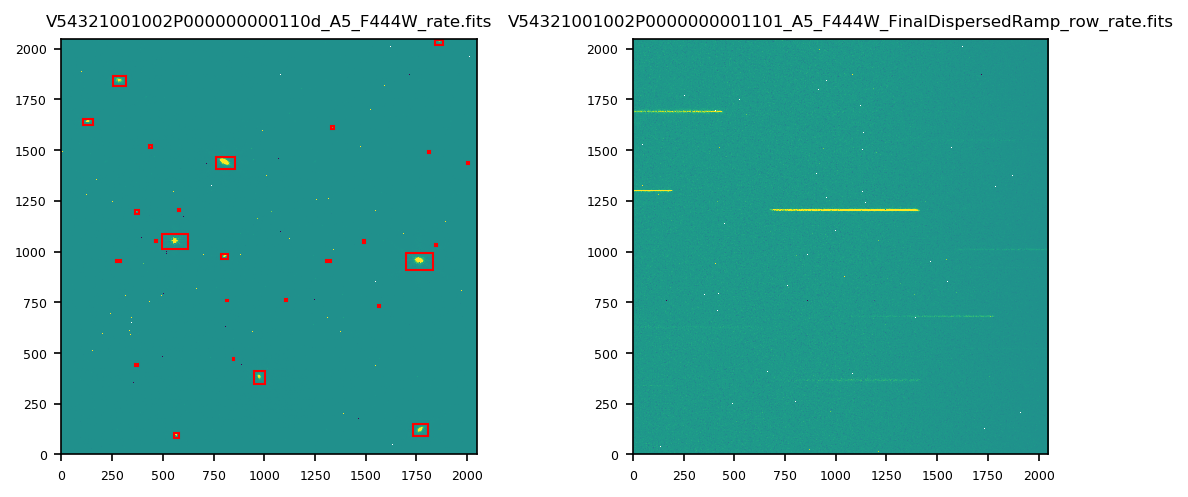

In [22]:
# display and save a jpeg copy of the results 
dispim=fits.getdata(grismr_file, ext=1)
dirim=fits.getdata(directr_file, ext=1)
ys,xs=dirim.data.shape
fig2 = plt.figure(figsize=(8,8), dpi=150)
ax1 = fig2.add_subplot(1, 2, 1)
ax1.ticklabel_format(useOffset=False)
ax1.set_title(directr_file.split("/")[-1], fontsize=8)
ax2 = fig2.add_subplot(1, 2, 2)
ax2.set_title(grismr_file.split("/")[-1], fontsize=8)

# rectangle patches are xmin, ymin, width, height
plist1=[]
for xmin,ymin,xmax,ymax in zip(det_bbox_ll_x, det_bbox_ll_y, det_bbox_ur_x,det_bbox_ur_y):
    plist1.append(patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red'))

for p in plist1:
    ax1.add_patch(p)
    
ax1.imshow(dirim, origin='lower', extent=[0,xs,0,ys], vmin=-10, vmax=10)
ax2.imshow(dispim, origin='lower', extent=[0,xs,0,ys], vmin=-5, vmax=5)
saveto = directr_file.split("/")[-1].split(".fits")[0]+"_boxes.jpg"
fig2.tight_layout()
fig2.savefig(saveto, dpi=120, bbox_inches='tight')
print("Saved jpeg file to: {}".format(saveto))

### Now we need to translate the minimum bounding boxes to the grism image
We'll do this by going through part of the GWCS object for the dispersed image

**Look at the nircam/Using-the-NIRCAM-WFSS-WCS-Object  notebook for explicit detail on the GWCS object, transforms and models for WFSS**

*Since the grism image is using the GWCS object at all stages, here we could  create the GWCS object for the direct image and use that to translate the bounding box corners, and object centers, to RA,DEC locations on the sky.
We would then use the GWCS object in the grism image to translate them back to detector pixel locations. The biggest difference here between the fits WCS and the GWCS is the trip through the distorion correction.* So there's errors in the location whether you do this through fits wcs or gwcs because the catalog is only using fits wcs right now.

In [23]:
# Lets read the file into a datamodel and display some information
grism_image = image.ImageModel(grismr_file)
grism_image.meta.instrument.name, grism_image.meta.instrument.filter, grism_image.meta.instrument.pupil, grism_image.meta.instrument.detector,grism_image.meta.exposure.type

('NIRCAM', 'F444W', 'GRISMR', 'NRCALONG', 'NRC_WFSS')

### Take a look at what is in the wcsinfo structure

In [24]:
gim=grism_image
gim.meta.wcsinfo.crval1, gim.meta.wcsinfo.crval2, gim.meta.wcsinfo.crpix1, gim.meta.wcsinfo.crpix2, gim.meta.wcsinfo.crpix3

(53.1423683802, -27.8171119969, 1024.5, 1024.5, None)

In [25]:
gim.meta.wcsinfo.wcsaxes, gim.meta.wcsinfo.ra_ref, gim.meta.wcsinfo.dec_ref, gim.meta.wcsinfo.v2_ref, gim.meta.wcsinfo.v3_ref

(2, 53.1423683802, -27.8171119969, 86.103458, -493.227512)

In [26]:
gim.meta.wcsinfo.roll_ref, gim.meta.wcsinfo.cdelt1, gim.meta.wcsinfo.cdelt2, gim.meta.wcsinfo.cdelt3

(45.04234459270135, 1.74460027777777e-05, 1.75306861111111e-05, None)

In [27]:
gim.meta.wcsinfo.pc1_1, gim.meta.wcsinfo.pc1_2, gim.meta.wcsinfo.pc2_1, gim.meta.wcsinfo.pc2_2

(-0.7076885519484576,
 0.7065245313795517,
 0.7065245313795517,
 0.7076885519484576)

In [28]:
junk=fits.open(grismr_file, mode='update')
junk[0].header['exp_type'] = 'NRC_WFSS'
junk.close()
fits.getval(grismr_file,'EXP_TYPE')

'NRC_WFSS'

### The original file still had NRC_GRISM instead of NRC_WFSS for exposure.type, update if necessary

In [29]:
wcs_step = assign_wcs.AssignWcsStep()

2019-01-11 14:55:31,276 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


In [30]:
grism_with_wcs = wcs_step(grism_image)

2019-01-11 14:55:31,784 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from V54321001002P0000000001101_A5_F444W_FinalDispersedRamp_row_rate.fits>,).
2019-01-11 14:55:34,154 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs
2019-01-11 14:55:34,164 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


In [31]:
grism_with_wcs.meta.wcs.available_frames  # this is where the WCS lives, available frames gives you the transforms that are available

['grism_detector', 'detector', 'v2v3', 'world']

#### What does the GWCS wcs information look like?

In [32]:
grism_with_wcs.meta.wcs

<WCS(output_frame=world, input_frame=grism_detector, forward_transform=Model: CompoundModel18
Inputs: ('x', 'y', 'x0', 'y0', 'order')
Outputs: ('ra', 'dec', 'x0', 'x1')
Model set size: 1
Expression: [0] | ([1] | [2] & [3] | [4] | [5] & [6]) & [7] | ([8] & [9] | [10]) & [11]
Components: 
    [0]: <NIRCAMForwardRowGrismDispersion(name='nircam_forward_row_grism_dispersion')>

    [1]: <Mapping((0, 1, 0, 1))>

    [2]: <Polynomial2D(5, c0_0=0., c1_0=0.0628056, c2_0=0.00000012, c3_0=0., c4_0=0., c5_0=0., c0_1=-0., c0_2=-0.0000001, c0_3=-0., c0_4=-0., c0_5=0., c1_1=-0.00000073, c1_2=0., c1_3=-0., c1_4=0., c2_1=-0., c2_2=0., c2_3=0., c3_1=-0., c3_2=0., c4_1=0.)>

    [3]: <Polynomial2D(5, c0_0=0., c1_0=-0.000048, c2_0=0.0000003, c3_0=-0., c4_0=0., c5_0=0., c0_1=0.0631105, c0_2=-0.00000044, c0_3=0., c0_4=-0., c0_5=0., c1_1=0.00000023, c1_2=-0., c1_3=0., c1_4=0., c2_1=0., c2_2=-0., c2_3=0., c3_1=0., c3_2=0., c4_1=0.)>

    [4]: <Mapping((0, 1, 0, 1))>

    [5]: <Polynomial2D(1, c0_0=0., c1_0=-0

#### This is what the FITS wcs information looks like for the grism image:

In [33]:
grism_fits_wcs = grism_image.get_fits_wcs()
grism_fits_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.1423683802  -27.8171119969  
CRPIX : 1024.5  1024.5  
PC1_1 PC1_2  : -0.7076885519484576  0.7065245313795517  
PC2_1 PC2_2  : 0.7065245313795517  0.7076885519484576  
CDELT : 1.74460027777777e-05  1.75306861111111e-05  
NAXIS : 2048  2048

In [34]:
# compare with the wcsinfo in the datamodel
grism_with_wcs.meta.wcsinfo.crval1, grism_with_wcs.meta.wcsinfo.crval2, grism_with_wcs.meta.wcsinfo.crpix1, grism_with_wcs.meta.wcsinfo.crpix2

(53.1423683802, -27.8171119969, 1024.5, 1024.5)

### Assuming that the grism image we are working with has the correct meta information about it's pointing, we can use the RA,DEC coordinates of the corners of the boxes to translate to a respective "direct image" that might have been taken at the same location as the grism image pointing.

In [35]:
catalog[18]

<Row index=18>
  id      xcentroid         ycentroid                  sky_centroid               area  source_sum source_sum_err semimajor_axis_sigma semiminor_axis_sigma     orientation                  sky_bbox_ll                          sky_bbox_ul                           sky_bbox_lr                          sky_bbox_ur               orientation_sky    abmag  abmag_error
             pix               pix                       deg,deg                  pix2                                    pix                  pix                  deg                        deg,deg                              deg,deg                               deg,deg                              deg,deg                       deg                            
int64      float64           float64                      object                float64  float32      float32           float64              float64              float64                       object                               object                                object                               object                     float64       float64   float32  
----- ----------------- ----------------- ------------------------------------- ------- ---------- -------------- -------------------- -------------------- ------------------- ------------------------------------- ------------------------------------ ------------------------------------- ------------------------------------ ------------------ ------- -----------
   19 805.2922935370586 1438.978856541085 53.15786614730031,-27.814422430047713  3950.0  47461.207       9.424652   10.240579756141942    4.998599189576314 -26.265879769088762 53.158024922014874,-27.81539255850512 53.15890283709383,-27.81461090409957 53.15668475033097,-27.814203596345116 53.15756266544928,-27.81342195041563 288.68696039908787     nan         nan

In [36]:
# Translated locations to effective grism image "direct image" using the FITS wcs information
gdet_bbox_ll_x, gdet_bbox_ll_y  = skycoord_to_pixel(catalog['sky_bbox_ll'], grism_fits_wcs, origin=0)
gdet_bbox_lr_x, gdet_bbox_lr_y  = skycoord_to_pixel(catalog['sky_bbox_lr'], grism_fits_wcs, origin=0)
gdet_bbox_ul_x, gdet_bbox_ul_y  = skycoord_to_pixel(catalog['sky_bbox_ul'], grism_fits_wcs, origin=0)
gdet_bbox_ur_x, gdet_bbox_ur_y  = skycoord_to_pixel(catalog['sky_bbox_ur'], grism_fits_wcs, origin=0)
xcenter,ycenter = skycoord_to_pixel(catalog['sky_centroid'], grism_fits_wcs, origin=0)

### Visual display of what the translation from object locations on our direct image to object locations on our grism "direct image"
The boxes in the grism image are at the location of the obect in the catalog, but at the pointing of the grism image so they should show the dither offset
The blue dots on the grism image mark the object center, just as translated by the fits_wcs, not the full trace size. See https://jwst-docs.stsci.edu/display/JTI/NIRCam+Grisms figure 3 for the example of how the source position relates to the trace location.

Saved jpeg file to: V54321001002P0000000001101_A5_F444W_FinalDispersedRamp_row_rate_F444w.jpg


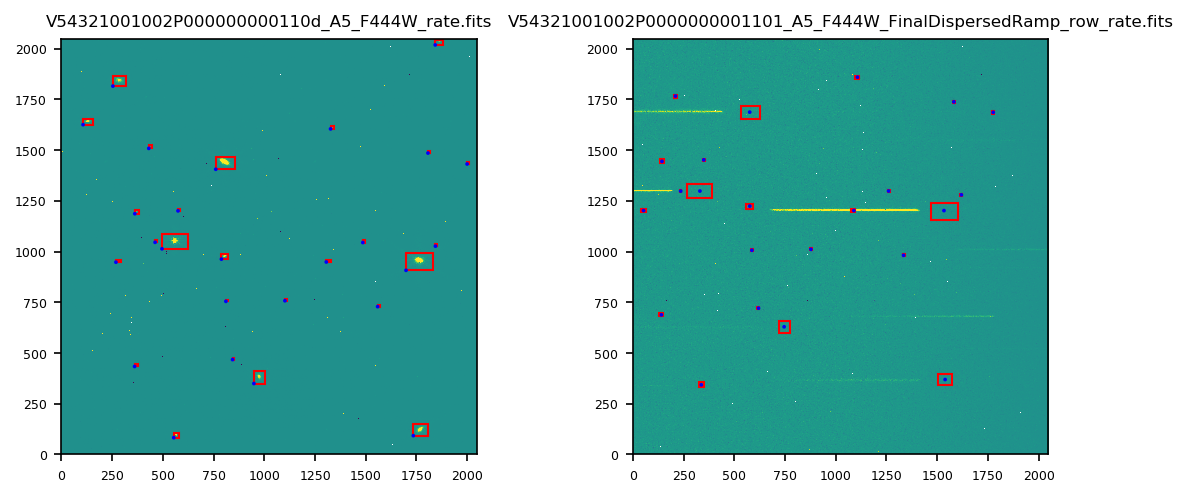

In [37]:
# display and save a jpeg copy of the results 
dispim=fits.getdata(grismr_file, ext=1)
dirim=fits.getdata(directr_file, ext=1)
ys,xs=dirim.data.shape
fig2 = plt.figure(figsize=(8,8), dpi=150)
ax1 = fig2.add_subplot(1, 2, 1)
ax1.ticklabel_format(useOffset=False)
ax1.set_title(directr_file.split("/")[-1], fontsize=8)
ax2 = fig2.add_subplot(1, 2, 2)
ax2.set_title(grismr_file.split("/")[-1], fontsize=8)

# rectangle patches are xmin, ymin, width, height
plist1=[]
for xmin,ymin,xmax,ymax,xc,yc in zip(gdet_bbox_ll_x, gdet_bbox_ll_y, gdet_bbox_ur_x, gdet_bbox_ur_y,xcenter,ycenter):
    plist1.append(patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red'))
    plist1.append(patches.Circle((xc, yc),4, color='blue'))

for p in plist1:
    ax2.add_patch(p)
    
plist1=[]
for xmin,ymin,xmax,ymax in zip(det_bbox_ll_x, det_bbox_ll_y, det_bbox_ur_x,det_bbox_ur_y):
    plist1.append(patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red'))
    plist1.append(patches.Circle((xmin, ymin),4, color='blue'))

for p in plist1:
    ax1.add_patch(p)
    
    
ax1.imshow(dirim, origin='lower', extent=[0,xs,0,ys], vmin=-10, vmax=10)
ax2.imshow(dispim, origin='lower', extent=[0,xs,0,ys], vmin=-5, vmax=5)
saveto = grismr_file.split("/")[-1].split(".fits")[0]+"_F444w.jpg"
fig2.tight_layout()
fig2.savefig(saveto, dpi=120, bbox_inches='tight')
print("Saved jpeg file to: {}".format(saveto))

### Now that we have the pixel locations from our fake direct image, we'll use  the transform from 'detector' to 'grism_detector' to translate the bounding box corner locations to the grism image itself

#### We are also going to need to use the `wavelengthrange` reference file
This tells us what the min and max wavelengths are for each spectral order and we'll use it to set the size of our extraction box in the dispersed image

#### Ask CRDS for the name of the wavelengthrange reference file that goes with this image
I'm doing this the long way as an example of how to do it by hand for any file.

How did I know how to populate the header information? Look at the rmaps in CRDS to see what its selecting against for your reference file. For NIRCAM wavelengthrange look here: https://jwst-crds.stsci.edu/browse/jwst_nircam_wavelengthrange_0008.rmap

In [40]:
import crds
from crds import client
jwst_context = client.get_default_context('jwst')
header = {"meta.instrument.name": grism_with_wcs.meta.instrument.name,
          "meta.instrument.module": grism_with_wcs.meta.instrument.module,
          "meta.exposure.type": grism_with_wcs.meta.exposure.type,
          "meta.observation.date": grism_with_wcs.meta.observation.date,
          "meta.observation.time": grism_with_wcs.meta.observation.time,
         }
wavelengthrange = client.get_best_references(jwst_context, header, ["wavelengthrange"])
wavelengthrange

{'wavelengthrange': 'jwst_nircam_wavelengthrange_0003.asdf'}

#### If you wanted to get a list of all the reference files that were needed by a particular jwst pipeline step, you could do this:


In [41]:
from jwst.extract_2d.extract_2d_step import Extract2dStep
e2d = Extract2dStep()
ref_types = e2d.reference_file_types
ref_types

2019-01-11 14:56:52,915 - stpipe.Extract2dStep - INFO - Extract2dStep instance created.


['wavecorr', 'wavelengthrange']

In [42]:
reference_file_names = {}
for name in ref_types:
    reffile = e2d.get_reference_file(grism_with_wcs, name)
    reference_file_names[name] = reffile if reffile else ""
reference_file_names

{'wavecorr': 'N/A',
 'wavelengthrange': '/Users/sosey/crds_cache/references/jwst/nircam/jwst_nircam_wavelengthrange_0003.asdf'}

**No file should have been returned for wavecorr because it's not currently used in this mode**

In [43]:
with WavelengthrangeModel(reference_file_names['wavelengthrange']) as f:
        wavelengthrange = f.wavelengthrange
        waverange_selector = f.waverange_selector
        order = f.order
f.instance  # show everything in the file

{'asdf_library': {'author': 'Space Telescope Science Institute',
  'homepage': 'http://github.com/spacetelescope/asdf',
  'name': 'asdf',
  'version': '2.1.0.dev1466'},
 'history': {'entries': [{'description': 'Ground NIRCAM Grism wavelengthrange',
    'software': {'author': 'STScI',
     'homepage': 'https://github.com/spacetelescope/jwreftools',
     'name': 'nircam_reftools.py',
     'version': '0.7.1'},
    'time': datetime.datetime(2018, 8, 30, 22, 59, 39, 399367)}],
  'extensions': [<asdf.tags.core.ExtensionMetadata at 0xb2eeb6518>,
   <asdf.tags.core.ExtensionMetadata at 0xb2eeb60b8>]},
 'extract_orders': [['F250M', [1, 2]],
  ['F277W', [1, 2]],
  ['F300M', [1, 2]],
  ['F322W2', [1, 2]],
  ['F335M', [1, 2]],
  ['F356W', [1, 2]],
  ['F360M', [1, 2]],
  ['F410M', [1, 2]],
  ['F430M', [1, 2]],
  ['F444W', [1, 2]],
  ['F460M', [1, 2]],
  ['F480M', [1, 2]]],
 'meta': {'author': 'STScI',
  'date': '2018-08-30T18:59:39.389',
  'description': 'NIRCAM Grism-Filter Wavelength Ranges',
  '

### Instead of using the wavelengthrange reference file from CRDS, I'm going to use a local one that I'm testing, it has some different memebers that will allow us to specify explicit orders for extraction, the new one also reformats the wavelengthrange member to be a list of `[order, filter, minwave, maxwave]`

In [44]:
with WavelengthrangeModel('nircam_wfss_wavelengthrange.asdf') as f:
        wavelengthrange = f.wavelengthrange
        waverange_selector = f.waverange_selector
        orders = f.order
        extract_orders = f.extract_orders
f.instance  # show everything in the file

{'asdf_library': {'author': 'Space Telescope Science Institute',
  'homepage': 'http://github.com/spacetelescope/asdf',
  'name': 'asdf',
  'version': '2.1.0.dev1466'},
 'history': {'entries': [{'description': 'Ground NIRCAM Grism wavelengthrange',
    'software': {'author': 'STScI',
     'homepage': 'https://github.com/spacetelescope/jwreftools',
     'name': 'nircam_reftools.py',
     'version': '0.7.1'},
    'time': datetime.datetime(2018, 8, 30, 22, 59, 39, 399367)}],
  'extensions': [<asdf.tags.core.ExtensionMetadata at 0x109cbcd30>,
   <asdf.tags.core.ExtensionMetadata at 0x109cbcbe0>]},
 'extract_orders': [['F250M', [1, 2]],
  ['F277W', [1, 2]],
  ['F300M', [1, 2]],
  ['F322W2', [1, 2]],
  ['F335M', [1, 2]],
  ['F356W', [1, 2]],
  ['F360M', [1, 2]],
  ['F410M', [1, 2]],
  ['F430M', [1, 2]],
  ['F444W', [1, 2]],
  ['F460M', [1, 2]],
  ['F480M', [1, 2]]],
 'meta': {'author': 'STScI',
  'date': '2018-08-30T18:59:39.389',
  'description': 'NIRCAM Grism-Filter Wavelength Ranges',
  '

#### The wavelength ranges are contained in the `wavelengthrange` data member, which is a list of (order, filter, wave min, wave max)
The range can be selected using just the wavelengthrange member, in the most recent reference file, the `waverange_selector` and `order` members represent lists of the available for easy reference


In [45]:
print("wavelengthrange: {}\n\nwaverange_selector: {}\n\norder: {}".format(wavelengthrange, waverange_selector, orders))

wavelengthrange: [[1, 'F250M', 2.500411072, 4.800260833], [1, 'F277W', 2.500411072, 3.807062006], [1, 'F300M', 2.684896869, 4.025318456], [1, 'F322W2', 2.5011293930000003, 4.215842089], [1, 'F335M', 3.01459734, 4.260432726], [1, 'F356W', 3.001085025, 4.302320901], [1, 'F360M', 3.178096344, 4.00099629], [1, 'F410M', 3.6267051809999997, 4.5644598], [1, 'F430M', 4.04828939, 4.511761774], [1, 'F444W', 3.696969216, 4.899565197], [1, 'F460M', 3.103778615, 4.881999188], [1, 'F480M', 4.5158154679999996, 4.899565197], [2, 'F250M', 2.500411072, 2.667345336], [2, 'F277W', 2.500411072, 3.2642254050000004], [2, 'F300M', 2.6659796289999997, 3.2997071729999994], [2, 'F322W2', 2.5011293930000003, 4.136119434], [2, 'F335M', 2.54572003, 3.6780519760000003], [2, 'F356W', 2.529505253, 4.133416971], [2, 'F360M', 2.557881113, 4.83740855], [2, 'F410M', 2.5186954019999996, 4.759037127], [2, 'F430M', 2.5362614100000003, 4.541488865], [2, 'F444W', 2.5011293930000003, 4.899565197], [2, 'F460M', 2.575447122, 4.88

#### Find the wavelength ranges to use with the filter we have for the order we specify, make sure they are correct

In [46]:
order = 1
range_select = [(x[2], x[3]) for x in wavelengthrange if (x[0] == order and x[1] == grism_image.meta.instrument.filter)]
lmin, lmax = range_select.pop()
print("Order: {}\nFilter: {}\nWav min: {}\nWav max: {}\n".format(order, grism_image.meta.instrument.filter, lmin, lmax))

Order: 1
Filter: F444W
Wav min: 3.696969216
Wav max: 4.899565197



#### Moving on, let's make boxes for each dispersed spectral object using the corner locations and the wavelengths
SkyObject below is used by the WFSS methods to track grism objects from the catalog, we can display the parts of the catalog it cares about:

In [47]:
from jwst.lib.catalog_utils import SkyObject
required_fields = list(SkyObject()._fields)
print(required_fields)

['sid', 'xcentroid', 'ycentroid', 'sky_centroid', 'abmag', 'abmag_error', 'sky_bbox_ll', 'sky_bbox_lr', 'sky_bbox_ul', 'sky_bbox_ur']


#### Get the information we need from the catalog

In [48]:
from jwst.assign_wcs import util
grism_objects = util.get_object_info(skycoord_cat)

In [49]:
grism_objects[18]

SkyObject(sid=19, xcentroid=<Quantity 805.29229354 pix>, ycentroid=<Quantity 1438.97885654 pix>, sky_centroid=<SkyCoord (ICRS): (ra, dec) in deg
    (53.15786615, -27.81442243)>, abmag=nan, abmag_error=nan, sky_bbox_ll=<SkyCoord (ICRS): (ra, dec) in deg
    (53.15802492, -27.81539256)>, sky_bbox_lr=<SkyCoord (ICRS): (ra, dec) in deg
    (53.15668475, -27.8142036)>, sky_bbox_ul=<SkyCoord (ICRS): (ra, dec) in deg
    (53.15890284, -27.8146109)>, sky_bbox_ur=<SkyCoord (ICRS): (ra, dec) in deg
    (53.15756267, -27.81342195)>)

#### We're going to do this example for just the FIRST SPECTRAL ORDER
Also, remember that `wcs` is the FITS wcs object that we created from the direct image

#### Translated locations to effective grism image "direct image"
    gdet_bbox_ll_x, gdet_bbox_ll_y  = skycoord_to_pixel(catalog['sky_bbox_ll'], grism_fits_wcs, origin=0)
    gdet_bbox_lr_x, gdet_bbox_lr_y  = skycoord_to_pixel(catalog['sky_bbox_lr'], grism_fits_wcs, origin=0)
    gdet_bbox_ul_x, gdet_bbox_ul_y  = skycoord_to_pixel(catalog['sky_bbox_ul'], grism_fits_wcs, origin=0)
    gdet_bbox_ur_x, gdet_bbox_ur_y  = skycoord_to_pixel(catalog['sky_bbox_ur'], grism_fits_wcs, origin=0)

## Replace the NaN values for abmag with something that will pass the code for now

In [50]:
tempcat=QTable.read(skycoord_cat,  format='ascii.ecsv')
tempcat["abmag"][:] = 18.
tempcat.write(skycoord_cat, overwrite=True)

In [51]:
tempcat[:][18]

<Row index=18>
  id      xcentroid         ycentroid                  sky_centroid               area  source_sum source_sum_err semimajor_axis_sigma semiminor_axis_sigma     orientation                  sky_bbox_ll                          sky_bbox_ul                           sky_bbox_lr                          sky_bbox_ur               orientation_sky    abmag  abmag_error
             pix               pix                       deg,deg                  pix2                                    pix                  pix                  deg                        deg,deg                              deg,deg                               deg,deg                              deg,deg                       deg                            
int64      float64           float64                      object                float64  float32      float32           float64              float64              float64                       object                               object                                object                               object                     float64       float64   float32  
----- ----------------- ----------------- ------------------------------------- ------- ---------- -------------- -------------------- -------------------- ------------------- ------------------------------------- ------------------------------------ ------------------------------------- ------------------------------------ ------------------ ------- -----------
   19 805.2922935370586 1438.978856541085 53.15786614730031,-27.814422430047713  3950.0  47461.207       9.424652   10.240579756141942    4.998599189576314 -26.265879769088762 53.158024922014874,-27.81539255850512 53.15890283709383,-27.81461090409957 53.15668475033097,-27.814203596345116 53.15756266544928,-27.81342195041563 288.68696039908787    18.0         nan

### I've added the `use_fits_wcs` parameter here to make pipeline testing easier until `source_catalog` uses the gwcs object for location translation

In [52]:
reference_file_names['wavelengthrange'] = 'nircam_wfss_wavelengthrange.asdf'  # use our new file
grism_with_wcs.meta.source_catalog.filename= skycoord_cat  # assign the catalog we made to the image
test_boxes=assign_wcs.util.create_grism_bbox(grism_with_wcs, reference_file_names, use_fits_wcs=True)

2019-01-11 14:57:23,128 - stpipe - INFO - Using fits_wcs object for sky->detector translations
2019-01-11 14:57:23,130 - stpipe - INFO - Extracting objects < abmag = 99.0
2019-01-11 14:57:23,131 - stpipe - INFO - Getting objects from step_SourceCatalogStep_cat.ecsv
2019-01-11 14:57:23,469 - stpipe - INFO - Using default order extraction from reference file
2019-01-11 14:57:23,481 - stpipe - INFO - Partial order on detector for obj: 1 order: 2
2019-01-11 14:57:23,488 - stpipe - INFO - Partial order on detector for obj: 2 order: 1
2019-01-11 14:57:23,493 - stpipe - INFO - Excluding off-image object: 2, order 2
2019-01-11 14:57:23,509 - stpipe - INFO - Partial order on detector for obj: 3 order: 2
2019-01-11 14:57:23,518 - stpipe - INFO - Partial order on detector for obj: 4 order: 1
2019-01-11 14:57:23,523 - stpipe - INFO - Partial order on detector for obj: 4 order: 2
2019-01-11 14:57:23,532 - stpipe - INFO - Partial order on detector for obj: 5 order: 2
2019-01-11 14:57:23,543 - stpipe

### Take a look at one of the brighter objects (catalog #19)


In [53]:
test_boxes[18]

GrismObject(sid=19, order_bounding={1: ((1654, 1717), (292, 1586)), 2: ((1654, 1717), (1593, 6466))}, sky_centroid=<SkyCoord (ICRS): (ra, dec) in deg
    (53.15786615, -27.81442243)>, partial_order={1: False, 2: True}, waverange={1: (3.696969216, 4.899565197), 2: (2.5011293930000003, 4.899565197)}, sky_bbox_ll=<SkyCoord (ICRS): (ra, dec) in deg
    (53.15802492, -27.81539256)>, sky_bbox_lr=<SkyCoord (ICRS): (ra, dec) in deg
    (53.15668475, -27.8142036)>, sky_bbox_ur=<SkyCoord (ICRS): (ra, dec) in deg
    (53.15756267, -27.81342195)>, sky_bbox_ul=<SkyCoord (ICRS): (ra, dec) in deg
    (53.15890284, -27.8146109)>, xcentroid=array(575.83422562), ycentroid=array(1687.15072696))

In [54]:
test_boxes[-1]

GrismObject(sid=24, order_bounding={1: ((1874, 1900), (-361, 887)), 2: ((1874, 1900), (939, 5767))}, sky_centroid=<SkyCoord (ICRS): (ra, dec) in deg
    (53.17005294, -27.82030022)>, partial_order={1: True, 2: True}, waverange={1: (3.696969216, 4.899565197), 2: (2.5011293930000003, 4.899565197)}, sky_bbox_ll=<SkyCoord (ICRS): (ra, dec) in deg
    (53.1702213, -27.82076221)>, sky_bbox_lr=<SkyCoord (ICRS): (ra, dec) in deg
    (53.16950923, -27.82013063)>, sky_bbox_ur=<SkyCoord (ICRS): (ra, dec) in deg
    (53.16987152, -27.81980802)>, sky_bbox_ul=<SkyCoord (ICRS): (ra, dec) in deg
    (53.1705836, -27.82043959)>, xcentroid=array(-98.31186978), ycentroid=array(1886.2593439))

In [55]:
for source in test_boxes:
    try:
        bounding = source.order_bounding[2]
        ymin,ymax = bounding[0]
        xmin,xmax = bounding[1]
        print("Found: {}\t{}".format(source.sid, source.order_bounding))
    except:
        pass

Found: 1	{1: ((331, 355), (86, 1311)), 2: ((331, 355), (1386, 6191))}
Found: 3	{1: ((598, 660), (481, 1731)), 2: ((598, 660), (1781, 6611))}
Found: 4	{1: ((682, 695), (-106, 1105)), 2: ((682, 695), (1193, 5985))}
Found: 5	{1: ((716, 726), (376, 1582)), 2: ((716, 726), (1676, 6462))}
Found: 7	{1: ((1003, 1011), (343, 1550)), 2: ((1003, 1011), (1643, 6430))}
Found: 8	{1: ((1006, 1016), (634, 1841)), 2: ((1006, 1016), (1934, 6721))}
Found: 10	{1: ((1196, 1208), (-199, 1025)), 2: ((1196, 1208), (1101, 5905))}
Found: 12	{1: ((1211, 1236), (320, 1551)), 2: ((1211, 1236), (1621, 6431))}
Found: 13	{1: ((1262, 1335), (27, 1351)), 2: ((1262, 1335), (1328, 6231))}
Found: 16	{1: ((1294, 1303), (-6, 1198)), 2: ((1294, 1303), (1294, 6078))}
Found: 17	{1: ((1435, 1455), (-106, 1112)), 2: ((1435, 1455), (1194, 5992))}
Found: 18	{1: ((1449, 1456), (106, 1314)), 2: ((1449, 1456), (1407, 6194))}
Found: 19	{1: ((1654, 1717), (292, 1586)), 2: ((1654, 1717), (1593, 6466))}
Found: 22	{1: ((1757, 1773), (-37,

In [56]:
### Verify that the centroid of the object got calculated correctly 
x,y = skycoord_to_pixel(catalog[18]['sky_centroid'], grism_fits_wcs, origin=0)
print(x,y)

575.8342256164716 1687.1507269627728


### Visual verification of order bounding in the grism image

Saved figure to V54321001002P0000000001101_A5_F444W_FinalDispersedRamp_row_rate.fits_order_bounding.jpg


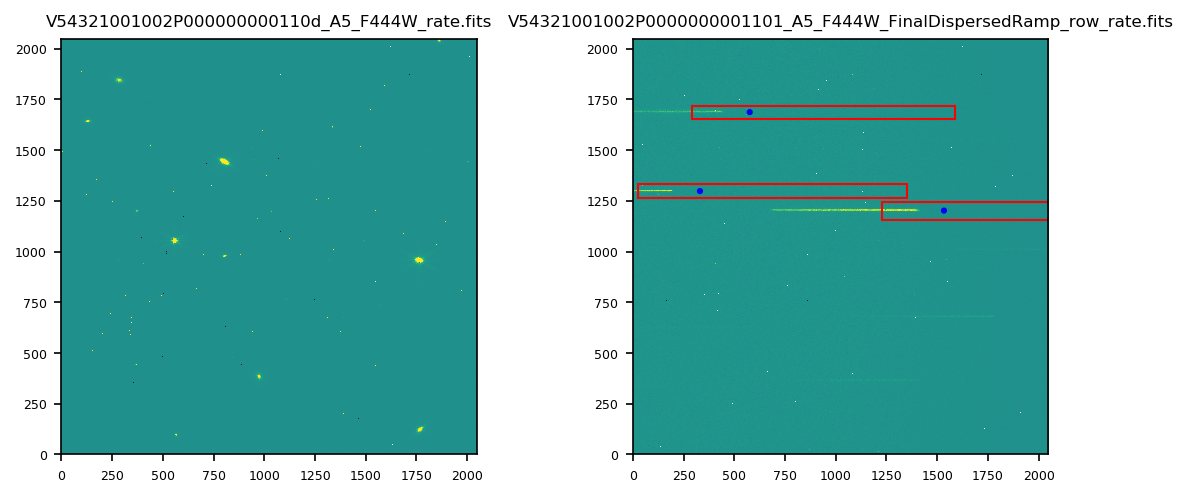

In [57]:
# visualize the images with some bounding boxes
ys,xs = dirim.shape  # assuming both are the same shape
fig2 = plt.figure(figsize=(8,8), dpi=150)

# Plot the direct image
ax1 = fig2.add_subplot(1, 2, 1)
ax1.ticklabel_format(useOffset=False)
ax1.set_title(directr_file.split("/")[-1], fontsize=8)

# Plot the grism image
ax2 = fig2.add_subplot(1, 2, 2)
ax1.ticklabel_format(useOffset=False)
ax2.set_title(grismr_file.split("/")[-1], fontsize=8)

# rectangle patches are xmin, ymin, width, height
order=1
tt = [test_boxes[18], test_boxes[12], test_boxes[8]]
for obj in tt:
    try:
        y,x  = obj.order_bounding[order]
        ymin, ymax = y
        xmin, xmax = x
        xcenter, ycenter = obj.xcentroid, obj.ycentroid
        ax2.add_patch(patches.Rectangle((xmin, ymin),
                                     xmax - xmin,
                                     ymax - ymin,
                                     fill=False, color='red'))
        ax2.add_patch(patches.Circle((xcenter, ycenter), 10, color='blue'))
    except KeyError:
        pass

ax1.imshow(dirim, origin='lower', extent=[0,xs,0,ys], vmin=-10, vmax=10)
ax2.imshow(dispim, origin='lower', extent=[0,xs,0,ys], vmin=-10, vmax=10)
fig2.tight_layout()
figname = grismr_file.split("/")[-1]+'_order_bounding.jpg'
fig2.savefig(figname, dpi=120, bbox_inches='tight')
print("Saved figure to {}".format(figname))

## The boxes are off a bit? The source location and box draw are what I expect for F444W, but the image looks more like F335M
What if we translate the boxes assuming that the filter *was* F335M

In [58]:
grismr_335m_file = "/Users/sosey/ssb/jwst-pipeline/jwst-pipeline-notebooks/data/nircam/V54321001002P0000000001101_A5_F444W_FinalDispersedRamp_row_rate_f335m.fits"

In [59]:
# Lets read the file into a datamodel and display some information
grism_image = image.ImageModel(grismr_335m_file)
grism_image.meta.instrument.name, grism_image.meta.instrument.filter, grism_image.meta.instrument.pupil, grism_image.meta.instrument.detector,grism_image.meta.exposure.type

('NIRCAM', 'F335M', 'GRISMR', 'NRCALONG', 'NRC_WFSS')

In [60]:
wcs_step = assign_wcs.AssignWcsStep()

2019-01-11 14:57:41,604 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


In [61]:
grism_with_wcs = wcs_step(grism_image)

2019-01-11 14:57:42,209 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from V54321001002P0000000001101_A5_F444W_FinalDispersedRamp_row_rate_f335m.fits>,).
2019-01-11 14:57:42,908 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs
2019-01-11 14:57:42,917 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


In [62]:
skycoord_cat='step_SourceCatalogStep_cat.ecsv'  # this should be the name in the output listing above
catalog=QTable.read(skycoord_cat,  format='ascii.ecsv')
catalog

<QTable length=26>
  id      xcentroid          ycentroid      ...  abmag  abmag_error
             pix                pix         ...                    
int64      float64            float64       ... float64   float32  
----- ------------------ ------------------ ... ------- -----------
    1  566.5884580067268  95.01738214939468 ...    18.0         nan
    2  1768.356510600382 120.89696843514946 ...    18.0         nan
    3   974.981903579752 380.88236906246266 ...    18.0         nan
    4 369.92507863061206  440.0472069383215 ...    18.0         nan
    5  848.5632069398413  472.7131103403137 ...    18.0         nan
    6 1563.8032761238346  733.2698111309755 ...    18.0         nan
    7  815.8331350886955  758.3001435721127 ...    18.0         nan
    8 1106.7585647961853  762.6868094643409 ...    18.0         nan
    9 1762.8446187443838   953.654293812466 ...    18.0         nan
  ...                ...                ... ...     ...         ...
   17  372.7343851300843 1196.3601779774813 ...    18.0         nan
   18  578.9047581360659   1203.76188337848 ...    18.0         nan
   19  805.2922935370586  1438.978856541085 ...    18.0         nan
   20  2005.397574127638  1437.827820824233 ...    18.0         nan
   21 1811.6351045588221 1489.6236796206585 ...    18.0         nan
   22  439.3534687856962 1518.1198870893284 ...    18.0         nan
   23  1336.316431146143 1611.1469547193703 ...    18.0         nan
   24 131.15685574652738 1638.1239744841605 ...    18.0         nan
   25  286.2709905740931 1840.4092996608497 ...    18.0         nan
   26 1861.9024039098492 2035.4605774853148 ...    18.0         nan

#### the `source_catalog` step returns the xcentroid and ycentroid in pixel values, let's plot those over our image to see how the detections look

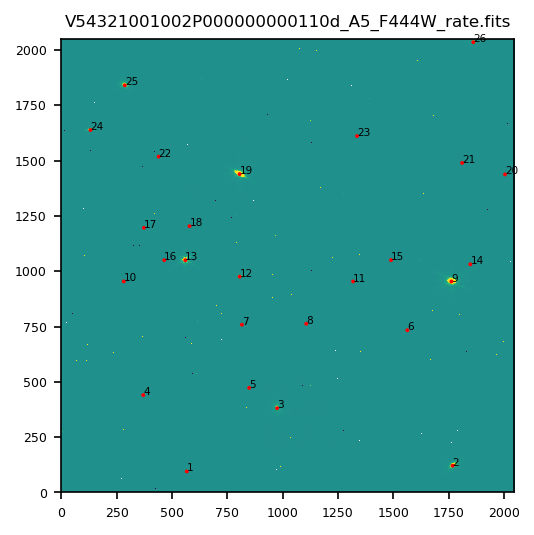

In [63]:
dirim = fits.getdata(directr_file, ext=1)
xs,ys=dirim.shape
fig = plt.figure(figsize=(4,4), dpi=150)
ax = fig.add_subplot(1, 1, 1)
ax.ticklabel_format(useOffset=False)
ax.set_title(directr_file.split("/")[-1], fontsize=8)
ax.imshow(dirim, origin='lower', extent=[0,xs,0,ys], vmin=-10, vmax=10)

# rectangle patches are xmin, ymin, width, height
plist1=[]
for obj in catalog:
    plist1.append(patches.Circle((obj['xcentroid'].value, obj['ycentroid'].value),4, color='red'))
    ax.text(obj['xcentroid'].value, obj['ycentroid'].value, obj['id'], size=5)

for p in plist1:
    ax.add_patch(p)
    
ax.imshow(dirim, origin='lower', extent=[0,xs,0,ys], vmin=-10, vmax=10)
fig.savefig('nircam_wfss_centers_f335m.jpg')

In [64]:
grism_fits_wcs = grism_with_wcs.get_fits_wcs()
grism_fits_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.1423683802  -27.8171119969  
CRPIX : 1024.5  1024.5  
PC1_1 PC1_2  : -0.7076885519484576  0.7065245313795517  
PC2_1 PC2_2  : 0.7065245313795517  0.7076885519484576  
CDELT : 1.74460027777777e-05  1.75306861111111e-05  
NAXIS : 2048  2048

In [65]:
# compare with the wcsinfo in the datamodel
grism_with_wcs.meta.wcsinfo.crval1, grism_with_wcs.meta.wcsinfo.crval2, grism_with_wcs.meta.wcsinfo.crpix1, grism_with_wcs.meta.wcsinfo.crpix2

(53.1423683802, -27.8171119969, 1024.5, 1024.5)

### Assuming that the grism image we are working with has the correct meta information about it's pointing, we can use the RA,DEC coordinates of the corners of the boxes to translate to a respective "direct image" that might have been taken at the same location as the grism image pointing.

In [66]:
# Translated locations to effective grism image "direct image" using the FITS wcs information
gdet_bbox_ll_x, gdet_bbox_ll_y  = skycoord_to_pixel(catalog['sky_bbox_ll'], grism_fits_wcs, origin=0)
gdet_bbox_lr_x, gdet_bbox_lr_y  = skycoord_to_pixel(catalog['sky_bbox_lr'], grism_fits_wcs, origin=0)
gdet_bbox_ul_x, gdet_bbox_ul_y  = skycoord_to_pixel(catalog['sky_bbox_ul'], grism_fits_wcs, origin=0)
gdet_bbox_ur_x, gdet_bbox_ur_y  = skycoord_to_pixel(catalog['sky_bbox_ur'], grism_fits_wcs, origin=0)
xcenter,ycenter = skycoord_to_pixel(catalog['sky_centroid'], grism_fits_wcs, origin=0)

### Visual display of what the translation from object locations on our direct image to object locations on our grism "direct image"
The boxes in the grism image are at the location of the obect in the catalog, but at the pointing of the grism image so they should show the dither offset
The blue dots on the grism image mark the object center, just as translated by the fits_wcs, not the full trace size. See https://jwst-docs.stsci.edu/display/JTI/NIRCam+Grisms figure 3 for the example of how the source position relates to the trace location.

Saved jpeg file to: V54321001002P0000000001101_A5_F444W_FinalDispersedRamp_row_rate_f335m.jpg


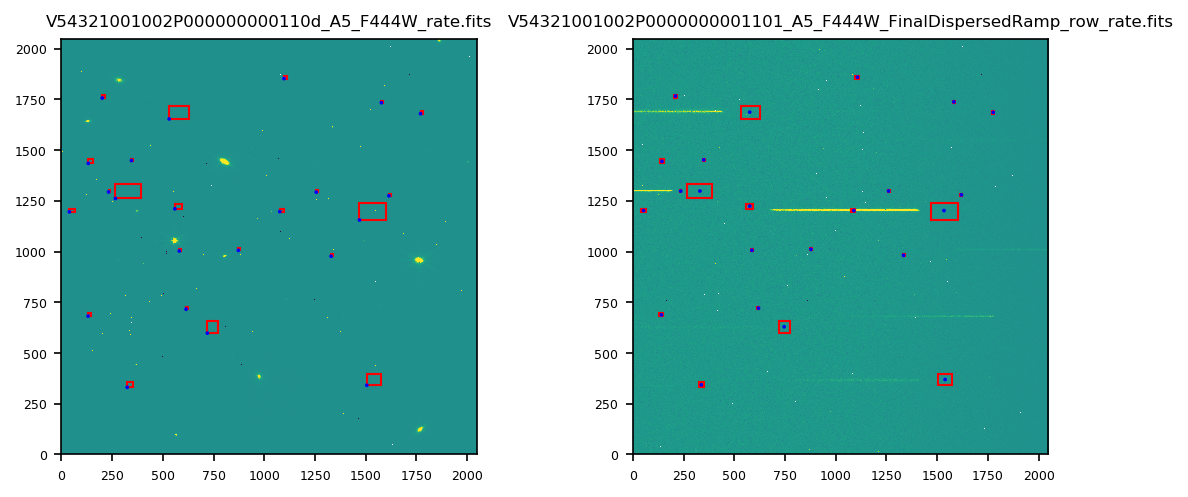

In [67]:
# display and save a jpeg copy of the results 
dispim=fits.getdata(grismr_file, ext=1)
dirim=fits.getdata(directr_file, ext=1)
ys,xs=dirim.data.shape
fig2 = plt.figure(figsize=(8,8), dpi=150)
ax1 = fig2.add_subplot(1, 2, 1)
ax1.ticklabel_format(useOffset=False)
ax1.set_title(directr_file.split("/")[-1], fontsize=8)
ax2 = fig2.add_subplot(1, 2, 2)
ax2.set_title(grismr_file.split("/")[-1], fontsize=8)

# rectangle patches are xmin, ymin, width, height
plist1=[]
for xmin,ymin,xmax,ymax,xc,yc in zip(gdet_bbox_ll_x, gdet_bbox_ll_y, gdet_bbox_ur_x, gdet_bbox_ur_y,xcenter,ycenter):
    plist1.append(patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red'))
    plist1.append(patches.Circle((xc, yc),4, color='blue'))

for p in plist1:
    ax2.add_patch(p)
    
plist1=[]
for xmin,ymin,xmax,ymax in zip(gdet_bbox_ll_x, gdet_bbox_ll_y, gdet_bbox_ur_x, gdet_bbox_ur_y):
    plist1.append(patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red'))
    plist1.append(patches.Circle((xmin, ymin),4, color='blue'))

for p in plist1:
    ax1.add_patch(p)
    
    
ax1.imshow(dirim, origin='lower', extent=[0,xs,0,ys], vmin=-10, vmax=10)
ax2.imshow(dispim, origin='lower', extent=[0,xs,0,ys], vmin=-5, vmax=5)
saveto = grismr_file.split("/")[-1].split(".fits")[0]+"_f335m.jpg"
fig2.tight_layout()
fig2.savefig(saveto, dpi=120, bbox_inches='tight')
print("Saved jpeg file to: {}".format(saveto))

In [68]:
from jwst import assign_wcs
from jwst.extract_2d.extract_2d_step import Extract2dStep
e2d = Extract2dStep()
ref_types = e2d.reference_file_types
ref_types

reference_file_names = {}
for name in ref_types:
    reffile = e2d.get_reference_file(grism_with_wcs, name)
    reference_file_names[name] = reffile if reffile else ""
reference_file_names

reference_file_names['wavelengthrange'] = 'nircam_wfss_wavelengthrange.asdf'  # use our new file
grism_with_wcs.meta.source_catalog.filename=skycoord_cat  # assign the catalog we made to the image
test_boxes=assign_wcs.util.create_grism_bbox(grism_with_wcs, reference_file_names, use_fits_wcs=True)

2019-01-11 14:58:01,735 - stpipe.Extract2dStep - INFO - Extract2dStep instance created.
2019-01-11 14:58:01,741 - stpipe - INFO - Using fits_wcs object for sky->detector translations
2019-01-11 14:58:01,742 - stpipe - INFO - Extracting objects < abmag = 99.0
2019-01-11 14:58:01,743 - stpipe - INFO - Getting objects from step_SourceCatalogStep_cat.ecsv
2019-01-11 14:58:01,938 - stpipe - INFO - Using default order extraction from reference file
2019-01-11 14:58:01,946 - stpipe - INFO - Partial order on detector for obj: 1 order: 1
2019-01-11 14:58:01,953 - stpipe - INFO - Partial order on detector for obj: 1 order: 2
2019-01-11 14:58:01,965 - stpipe - INFO - Excluding off-image object: 2, order 2
2019-01-11 14:58:01,973 - stpipe - INFO - Partial order on detector for obj: 3 order: 1
2019-01-11 14:58:01,978 - stpipe - INFO - Partial order on detector for obj: 3 order: 2
2019-01-11 14:58:01,984 - stpipe - INFO - Partial order on detector for obj: 4 order: 1
2019-01-11 14:58:01,988 - stpipe

### Visual verification of order bounding in the grism image

Saved figure to V54321001002P0000000001101_A5_F444W_FinalDispersedRamp_row_rate.fits_order_bounding_f335m.jpg


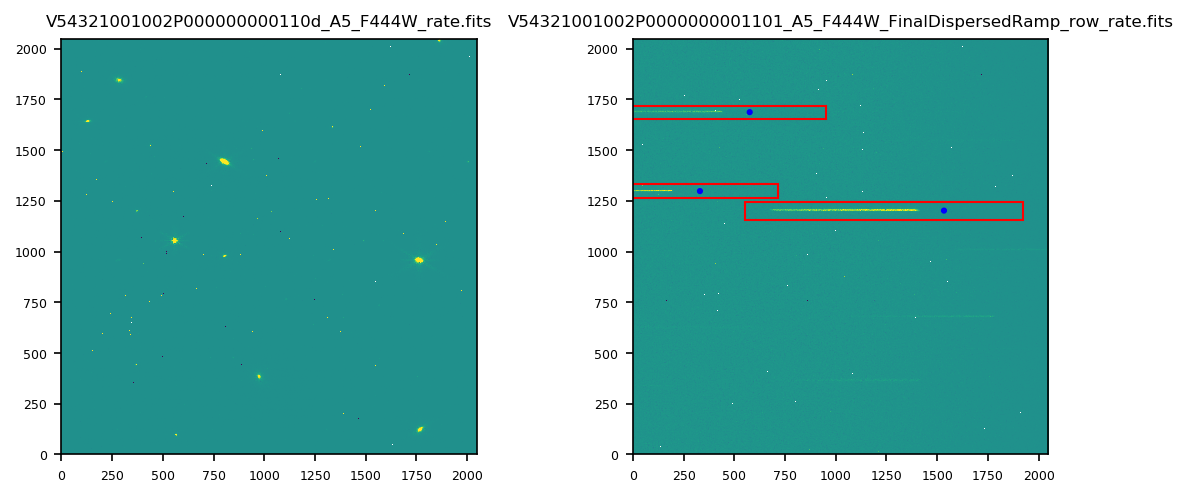

In [69]:
# visualize the images with some bounding boxes
ys,xs = dirim.shape  # assuming both are the same shape
fig2 = plt.figure(figsize=(8,8), dpi=150)

# Plot the direct image
ax1 = fig2.add_subplot(1, 2, 1)
ax1.ticklabel_format(useOffset=False)
ax1.set_title(directr_file.split("/")[-1], fontsize=8)

# Plot the grism image
ax2 = fig2.add_subplot(1, 2, 2)
ax1.ticklabel_format(useOffset=False)
ax2.set_title(grismr_file.split("/")[-1], fontsize=8)

# rectangle patches are xmin, ymin, width, height
order=1
tt = [test_boxes[18], test_boxes[12], test_boxes[8]]
for obj in tt:
    try:
        y,x  = obj.order_bounding[order]
        ymin, ymax = y
        xmin, xmax = x
        xcenter, ycenter = obj.xcentroid, obj.ycentroid
        ax2.add_patch(patches.Rectangle((xmin, ymin),
                                     xmax - xmin,
                                     ymax - ymin,
                                     fill=False, color='red'))
        ax2.add_patch(patches.Circle((xcenter, ycenter), 10, color='blue'))
    except KeyError:
        pass

ax1.imshow(dirim, origin='lower', extent=[0,xs,0,ys], vmin=-10, vmax=10)
ax2.imshow(dispim, origin='lower', extent=[0,xs,0,ys], vmin=-10, vmax=10)
fig2.tight_layout()
figname = grismr_file.split("/")[-1]+'_order_bounding_f335m.jpg'
fig2.savefig(figname, dpi=120, bbox_inches='tight')
print("Saved figure to {}".format(figname))

    [1, 'F335M', 3.01459734, 4.260432726]
    [1, 'F444W', 3.696969216, 4.899565197]
    
### From an email from nor, these should be the ranges
    F335M {'+2': [25457.2003, 36780.519760000003], '+1': [30145.973399999999, 42604.327260000005]}
    F444W {'+2': [25011.293930000003, 48995.651969999999], '+1': [36969.692159999999, 48995.651969999999]}
    

### If I continue on, let's just make sure that the order is extracted in the correct location for F335M

In [70]:
from jwst.extract_2d import extract_2d_step, extract_2d
step=extract_2d_step.Extract2dStep()
reference_file_names = {'camera': 'N/A',
 'collimator': 'N/A',
 'disperser': 'N/A',
 'distortion': step.get_reference_file(grism_with_wcs,'distortion'),
 'filteroffset': 'N/A',
 'fore': 'N/A',
 'fpa': 'N/A',
 'ifufore': 'N/A',
 'ifupost': 'N/A',
 'ifuslicer': 'N/A',
 'msa': 'N/A',
 'ote': 'N/A',
 'regions': 'N/A',
 'specwcs':  step.get_reference_file(grism_with_wcs,'specwcs'),
 'v2v3': 'N/A',
 'wavelengthrange': step.get_reference_file(grism_with_wcs, 'wavelengthrange')}

2019-01-11 14:58:12,407 - stpipe.Extract2dStep - INFO - Extract2dStep instance created.


In [71]:
reference_file_names['wavelengthrange'] = 'nircam_wfss_wavelengthrange.asdf'  # use our new file

In [72]:
x2d = extract_2d.extract_grism_objects(grism_with_wcs, reference_files=reference_file_names, mmag_extract=99., use_fits_wcs=True)

2019-01-11 14:58:14,618 - stpipe - INFO - Using fits_wcs object for sky->detector translations
2019-01-11 14:58:14,618 - stpipe - INFO - Extracting objects < abmag = 99.0
2019-01-11 14:58:14,619 - stpipe - INFO - Getting objects from step_SourceCatalogStep_cat.ecsv
2019-01-11 14:58:14,787 - stpipe - INFO - Using default order extraction from reference file
2019-01-11 14:58:14,793 - stpipe - INFO - Partial order on detector for obj: 1 order: 1
2019-01-11 14:58:14,798 - stpipe - INFO - Partial order on detector for obj: 1 order: 2
2019-01-11 14:58:14,816 - stpipe - INFO - Excluding off-image object: 2, order 2
2019-01-11 14:58:14,824 - stpipe - INFO - Partial order on detector for obj: 3 order: 1
2019-01-11 14:58:14,831 - stpipe - INFO - Partial order on detector for obj: 3 order: 2
2019-01-11 14:58:14,841 - stpipe - INFO - Partial order on detector for obj: 4 order: 1
2019-01-11 14:58:14,848 - stpipe - INFO - Partial order on detector for obj: 4 order: 2
2019-01-11 14:58:14,855 - stpipe

2019-01-11 14:58:22,967 - stpipe - INFO - Subarray extents are: (xmin:0, xmax:715), (ymin:1262, ymax:1335)
2019-01-11 14:58:23,299 - stpipe - INFO - Subarray extracted for obj: 13 order: 2:
2019-01-11 14:58:23,300 - stpipe - INFO - Subarray extents are: (xmin:1416, xmax:2048), (ymin:1262, ymax:1335)
2019-01-11 14:58:23,620 - stpipe - INFO - Subarray extracted for obj: 14 order: 1:
2019-01-11 14:58:23,621 - stpipe - INFO - Subarray extents are: (xmin:696, xmax:1947), (ymin:1275, ymax:1285)
2019-01-11 14:58:23,923 - stpipe - INFO - Subarray extracted for obj: 15 order: 1:
2019-01-11 14:58:23,924 - stpipe - INFO - Subarray extents are: (xmin:338, xmax:1588), (ymin:1293, ymax:1304)
2019-01-11 14:58:24,377 - stpipe - INFO - Subarray extracted for obj: 16 order: 1:
2019-01-11 14:58:24,378 - stpipe - INFO - Subarray extents are: (xmin:0, xmax:562), (ymin:1294, ymax:1303)
2019-01-11 14:58:24,743 - stpipe - INFO - Subarray extracted for obj: 16 order: 2:
2019-01-11 14:58:24,744 - stpipe - INFO 

In [73]:
len(x2d.slits)

39

In [74]:
x2d.write('nircam_extract_2d_wfss_slits_f335M.fits')
!ls -altr *.fits

-rwxr-xr--  1 sosey  STSCI\science   83934720 Apr 16  2018 V54321001002P000000000110d_A5_F444W_rate.fits
-rwxr-xr--  1 sosey  STSCI\science   83934720 Apr 16  2018 V54321001002P0000000001101_A5_F444W_FinalDispersedRamp_row_rate.fits
-rwxr-xr--  1 sosey  STSCI\science   83934720 Apr 16  2018 V54321001002P000000000110g_A5_F444W_FinalDispersedRamp_column_rate.fits
-rwxr-xr--  1 sosey  STSCI\science   83934720 Apr 16  2018 V54321001002P000000000110s_A5_F444W_rate.fits
-rw-r--r--  1 sosey  STSCI\science  100707840 Apr 24  2018 test_disperse_f335m_rate_updated.fits
-rw-r--r--  1 sosey  STSCI\science   50385600 Apr 30  2018 nircam_bad_grism_spec.fits
-rw-r--r--  1 sosey  STSCI\science   50385600 Apr 30  2018 itblends.fits
-rw-r--r--  1 sosey  STSCI\science   50385600 Apr 30  2018 copy_output_model.fits
-rwxr-xr-x  1 sosey  STSCI\science   50371200 Jul 11  2018 dispersed_ramp_from_test_disperser.bash.fitrate.fits
-rw-r--r--  1 sosey  STSCI\science  393278400 Sep  5 17:01 tso_wcs_assigned_test_

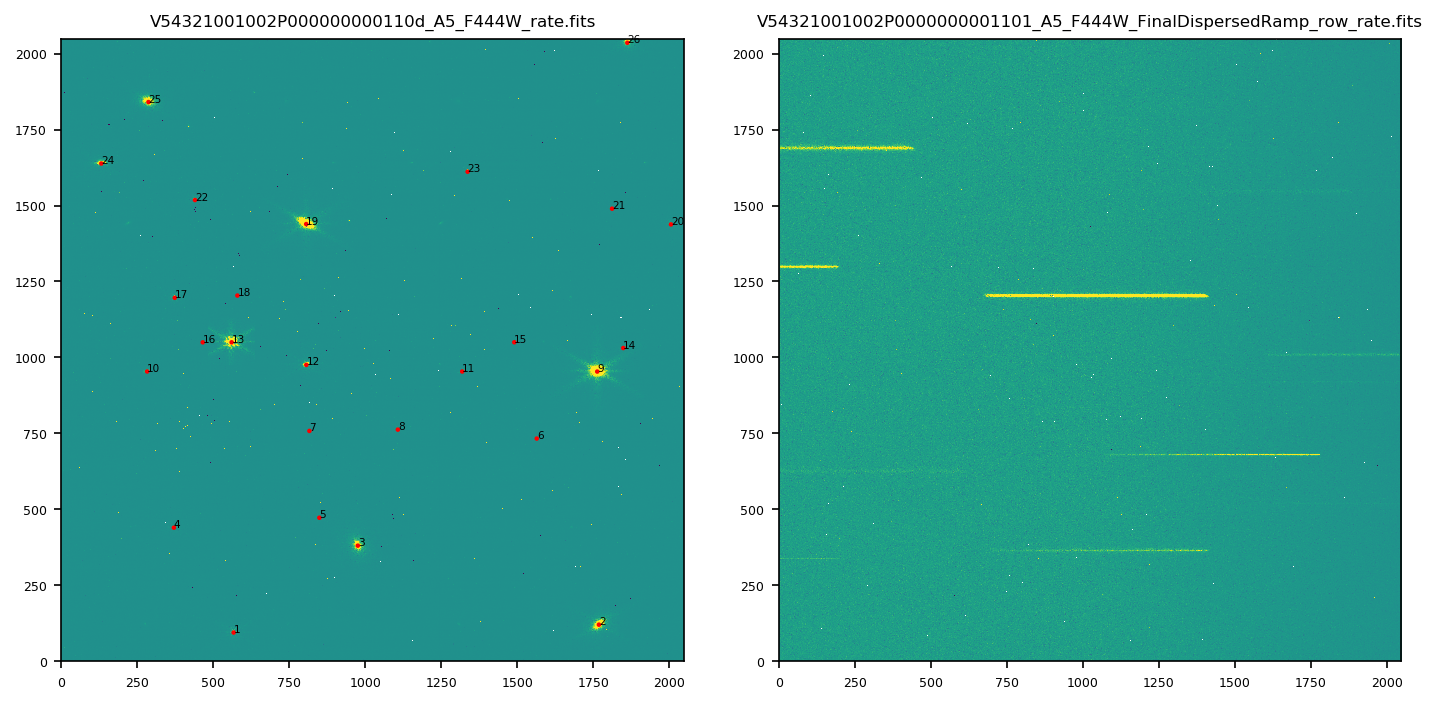

In [75]:
dispim=fits.getdata(grismr_file)
dirim=fits.getdata(directr_file)
ys,xs=dirim.data.shape

fig = plt.figure(figsize=(10,10), dpi=150)
ax3 = fig.add_subplot(1, 2, 1)
ax3.set_title(directr_file.split("/")[-1], fontsize=8)
ax3.imshow(dirim, origin='lower', extent=[0,xs,0,ys], vmin=-3, vmax=3)
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title(grismr_file.split("/")[-1], fontsize=8)
ax2.imshow(dispim, origin='lower', extent=[0,xs,0,ys], vmin=-3, vmax=3)
fig.tight_layout()


# rectangle patches are xmin, ymin, width, height
plist1=[]
for obj in catalog:
    plist1.append(patches.Circle((obj['xcentroid'].value, obj['ycentroid'].value),4, color='red'))
    ax3.text(obj['xcentroid'].value, obj['ycentroid'].value, obj['id'], size=5)

for p in plist1:
    ax3.add_patch(p)
ax3.imshow(dirim, origin='lower', extent=[0,xs,0,ys], vmin=-3, vmax=3)

Saved image to V54321001002P0000000001101_A5_F444W_FinalDispersedRamp_row_rate.fits_order_extracted_f335m.jpg


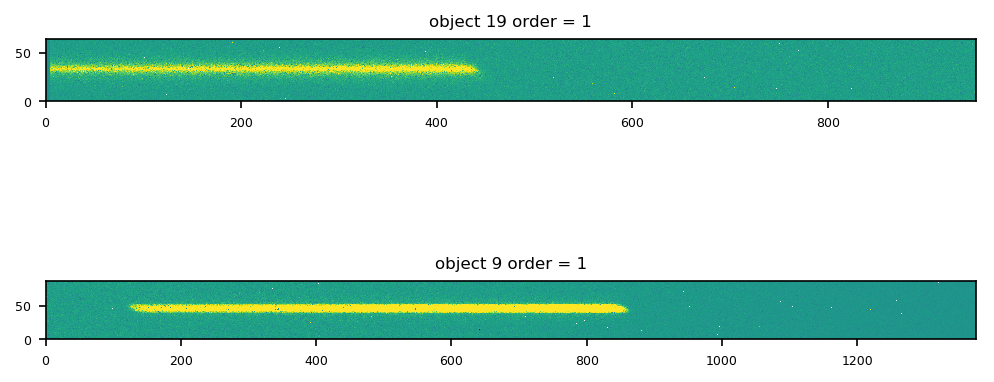

In [76]:
fig = plt.figure(figsize=(8,6), dpi=150)

ss=30
ys, xs = x2d.slits[ss].data.shape
ax = fig.add_subplot(3, 1, 1)
#xpos, ypos = x2d.slits[ss].source_xpos, x2d.slits[ss].source_ypos
#title = x2d.meta.instrument.filter+" order {0}\nx={1} y={2}".format(x2d.meta.wcsinfo.spectral_order,
#                                                                    xpos,
#                                                                    ypos)
title = "object {} order = {}".format(x2d.slits[ss].source_id, x2d.slits[ss].meta.wcsinfo.spectral_order)
ax.set_title(title, fontsize=8)
ax.imshow(x2d.slits[ss].data, origin='lower', extent=[0,xs,0,ys], vmin=-3, vmax=3)

ss=14
ys, xs = x2d.slits[ss].data.shape
ax4 = fig.add_subplot(3, 1, 2)
#xpos, ypos = x2d.slits[ss].source_xpos, x2d.slits[ss].source_ypos
#title = x2d.meta.instrument.filter+" order {0}\nx={1} y={2}".format(x2d.meta.wcsinfo.spectral_order,
#                                                                    xpos,
#                                                                    ypos)
title = "object {} order = {}".format(x2d.slits[ss].source_id, x2d.slits[ss].meta.wcsinfo.spectral_order)
ax4.set_title(title, fontsize=8)
ax4.imshow(x2d.slits[ss].data, origin='lower', extent=[0,xs,0,ys], vmin=-3, vmax=3)
figname = grismr_file.split("/")[-1]+'_order_extracted_f335m.jpg'
print("Saved image to {}".format(figname))
fig2.savefig(figname, dpi=120, bbox_inches='tight')

In [77]:
x2d.slits[30].source_id

19

In [78]:
x2d.slits[30].meta.wcs.bounding_box

((-0.5, 950.5), (-0.5, 63.5))

In [79]:
x2d.slits[30].source_xpos, x2d.slits[30].source_ypos #in full frame coordinates

(575.8342256164716, 1687.1507269627728)

In [80]:
x2d.meta.wcsinfo.crval1, x2d.meta.wcsinfo.crval2

(53.1423683802, -27.8171119969)

In [81]:
x2d.slits[30].meta.wcs(300, 45)

(53.24559353894091, -27.67442607541429, 3.6600624374534227, 1.0)

In [82]:
x2d.slits[30].meta.wcs.invert(53.24559353894091, -27.67442607541429, 3.6600624374534227, 1.0)  


(297.162793422298, 34.033261335390534)

In [83]:
x2d.slits[30].meta.wcs.available_frames

['grism_detector', 'detector', 'v2v3', 'world']

## Check out the objects and extraction sizes

In [84]:
i=0
for x in x2d.slits:
    print(i,x.source_id, x.meta.wcsinfo.spectral_order, x.xstart, x.ystart, x.xsize, x.ysize, x.source_xpos, x.source_ypos)
    i+=1

0 1 1 1 1 676 25 337.2033724434983 343.1759467130323
1 1 2 1 1 574 25 337.2033724434983 343.1759467130323
2 2 1 1 1 1312 57 1538.969680211454 369.1207532332975
3 3 1 1 1 1096 63 745.5811998494223 629.0631623446073
4 3 2 1 1 179 63 745.5811998494223 629.0631623446073
5 4 1 1 1 470 14 140.52131928496226 688.1951851672243
6 4 2 1 1 767 14 140.52131928496226 688.1951851672243
7 5 1 1 1 947 11 619.1575545212288 720.8870667527365
8 5 2 1 1 284 11 619.1575545212288 720.8870667527365
9 6 1 1 1 1252 10 1334.3832931470965 981.4826369473011
10 7 1 1 1 915 9 586.4119961562112 1006.4723969627152
11 7 2 1 1 317 9 586.4119961562112 1006.4723969627152
12 8 1 1 1 1206 11 877.3371122677559 1010.8748471393264
13 8 2 1 1 26 11 877.3371122677559 1010.8748471393264
14 9 1 1 1 1375 87 1533.4126254094704 1201.8779721231583
15 10 1 1 1 390 13 52.484982195228895 1202.100568010641
16 10 2 1 1 859 13 52.484982195228895 1202.100568010641
17 11 1 1 1 1263 12 1089.1413662018533 1202.1190257824571
18 12 1 1 1 916 26 